# Segmentation using classical CV methods

The objective of this notebook is to segment the face masks using the bounding box information from the annotation files (as opposed to the whole image). The main constraint will be to only use **classical** computer vision methods.

It is recommended to first go over the data_visualisation notebook to explore the dataset.

After observing images, we notice nearly all the masks share the same colors, that's why we will proceed with a color based segmentation algorithm.

In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

from utils_maskdataset import (
    display_multipleplots,
    display_RGBimageANDMask,
    extract_boxes,
    get_filenames_fromdir,
)

Our dataset is located in the **data/** folder.

In [3]:
dataset_path = Path("data")

Load the data filenames in python dicts.

In [4]:
train_filename_images = dict()
train_filename_labels = dict()
train_filename_images, train_filename_labels = get_filenames_fromdir(
    dataset_path, "train"
)

valid_filename_images = dict()
valid_filename_labels = dict()
valid_filename_images, valid_filename_labels = get_filenames_fromdir(
    dataset_path, "valid"
)

test_filename_images = dict()
test_filename_labels = dict()
test_filename_images, test_filename_labels = get_filenames_fromdir(dataset_path, "test")

train  :  105 images
valid  :  29 images
test  :  15 images


Let's write a function to display the masks for a specific training image.

In [5]:
def display_train_maskbbox(index):
    # read image
    img_path = dataset_path / "train" / train_filename_images[index]
    img = cv2.imread(str(img_path))  # BGR format
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # converts to RGB format

    # extract coords from annotation file
    boxes_mask, __, __, __ = extract_boxes(img_path.with_suffix(".xml"))

    # define the figure size and grid layout properties
    fig = plt.figure(figsize=(10, 8))
    columns = 3
    rows = len(boxes_mask)

    for index_loop, coords in enumerate(boxes_mask):
        Xmin, Ymin, Xmax, Ymax = coords[0], coords[1], coords[2], coords[3]

        # Adds a subplot to the index_loop position
        fig.add_subplot(rows, columns, index_loop + 1)

        # showing image
        rgb_img_segmented = rgb_img[Ymin:Ymax, Xmin:Xmax]
        plt.imshow(rgb_img_segmented)
        plt.axis("off")
        plt.title(index_loop + 1)

The majority of the face masks share the same color.

To make the segmentation more robust, we will go through the following steps : 
1. Convert to HSV
(HSV is more robust towards external lighting changes)
2. Blur the image to reduce the noise
3. Apply a threshold
4. Get the largest same object color

In [6]:
# Feel free to try different examples
IMAGE_NUMBER = 2

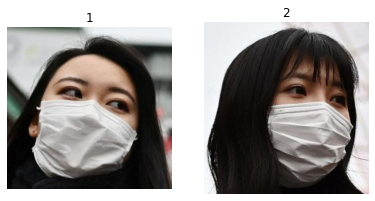

In [7]:
display_train_maskbbox(IMAGE_NUMBER)

In [8]:
# Take number from above
MASK_NUMBER = 1

1. Load the image and convert to HSV

In [9]:
boxes_mask, __, __, __ = extract_boxes(
    dataset_path / "train" / train_filename_labels[IMAGE_NUMBER]
)
coords = boxes_mask[MASK_NUMBER - 1]
Xmin, Ymin, Xmax, Ymax = coords[0], coords[1], coords[2], coords[3]

# read image and convert to various formats
img = cv2.imread(
    str(dataset_path / "train" / train_filename_images[IMAGE_NUMBER])
)  # BGR format (full image)
bgr_img = img[Ymin:Ymax, Xmin:Xmax]
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)  # converts to RGB format
hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)  # converts to HSV

2. Blur the image

In [10]:
# Apply blur to remove noise
blurred_bgr_img = cv2.blur(bgr_img, (3, 3))
blurred_rgb_img = cv2.blur(rgb_img, (3, 3))
blurred_hsv_img = cv2.blur(hsv_img, (3, 3))

3. Apply a threshold 

This step consists in finding the average HSV values for the Mask region. The simplest and quickest way to get these values is to load a software like GIMP and test a few images. 

Getting the HSV value (per pixel) from Gimp : 

*Windows / Dockable dialogs / Pointer*  
Put the pointer on the Blurred Image RGB, and select "Pixel" to "HSV" in dialog


In [11]:
# Experimental values obtained
H_avg, S_avg, V_avg = 21, 12, 178  # IMG 2 NUM 1

We apply a threshold. This value is not fixed as it should be finetuned depending on your dataset OR your application. 

In [12]:
thresh = 50  # 40
minHSV = np.array([H_avg - thresh, S_avg - thresh, V_avg - thresh])
maxHSV = np.array([H_avg + thresh, S_avg + thresh, V_avg + thresh])

# Threshold the HSV image to get only average HSV color from the mask region
maskHSV = cv2.inRange(blurred_hsv_img, minHSV, maxHSV)
# Bitwise-AND mask and original image
resultHSV = cv2.bitwise_and(blurred_hsv_img, blurred_hsv_img, mask=maskHSV)

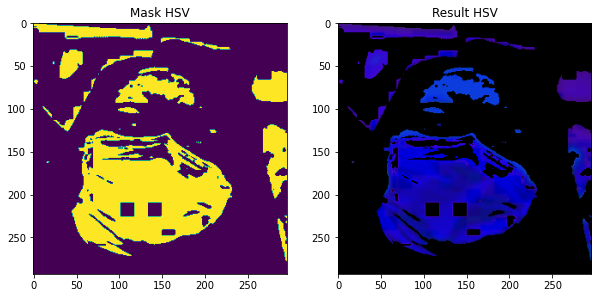

In [13]:
images_to_plot = [maskHSV, resultHSV]
images_title = ["Mask HSV", "Result HSV"]
display_multipleplots(images_to_plot, images_title, columns=2, rows=1, figsize=(10, 8))

4. Get the largest same object color (= largest connected component)

To refine our prediction, we only extract the largest object of the image. This is possible because we assume the mask has the same texture everywhere and it is the main element of the image.

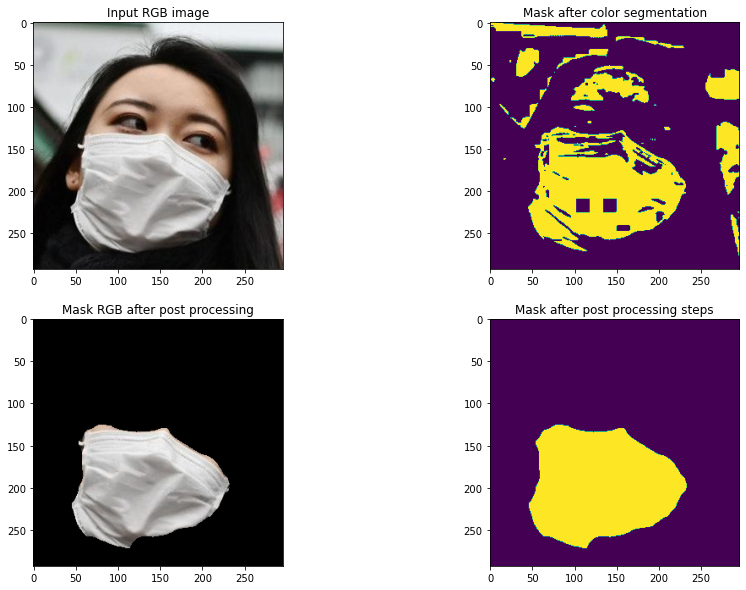

In [14]:
cnts, _ = cv2.findContours(maskHSV, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnt = max(cnts, key=cv2.contourArea)

# Output
out = np.zeros(maskHSV.shape, np.uint8)
cv2.drawContours(out, [cnt], -1, 255, cv2.FILLED)
out = cv2.bitwise_and(maskHSV, out)

# Smooth the mask (reduces number of small holes)
output_mask = cv2.morphologyEx(
    out, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (40, 40))
)
rgb_mask = cv2.bitwise_and(rgb_img, rgb_img, mask=output_mask)

# Plotting
images_to_plot = [rgb_img, maskHSV, rgb_mask, output_mask]
images_title = [
    "Input RGB image",
    "Mask after color segmentation",
    "Mask RGB after post processing",
    "Mask after post processing steps",
]
display_multipleplots(images_to_plot, images_title, columns=2, rows=2, figsize=(15, 10))

Some other examples:

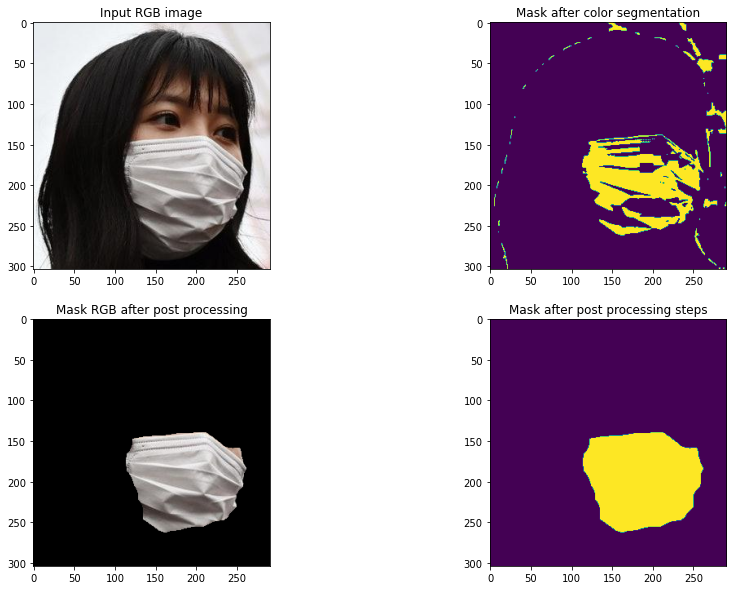

In [17]:
IMAGE_NUMBER = 2    # Check folder size for valid values
MASK_NUMBER = 2     # Values vary depending on annotation file
display_RGBimageANDMask(
    dataset_path / "train" / train_filename_images[IMAGE_NUMBER], MASK_NUMBER, 40
)

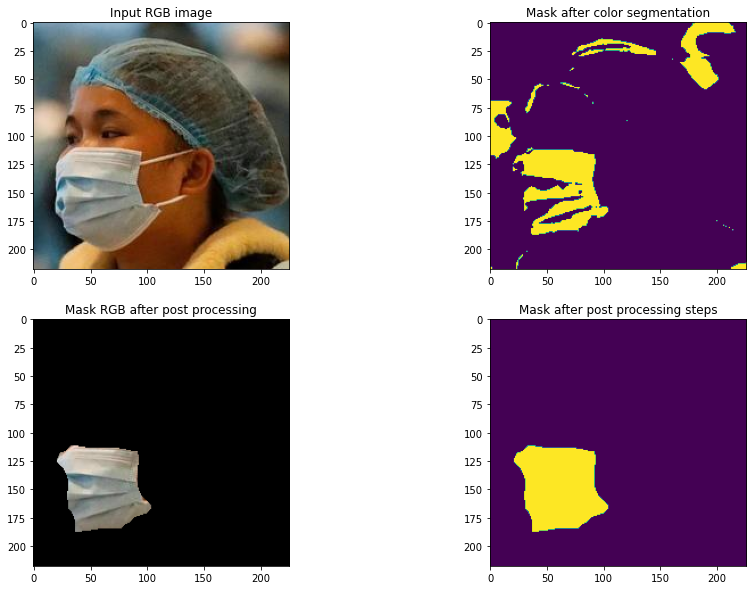

In [19]:
IMAGE_NUMBER = 5    # Check folder size for valid values
MASK_NUMBER = 1     # Values vary depending on annotation file
display_RGBimageANDMask(
    dataset_path / "train" / train_filename_images[IMAGE_NUMBER], MASK_NUMBER, 50
)